<a href="https://colab.research.google.com/github/CamCha0928/plane-classification/blob/main/notebook/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing data

In [1]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.3M      0  0:01:32  0:01:32 --:--:-- 28.8M


### Packages

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import yaml
import seaborn as sns
import datetime

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

#from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image

## Constantes

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
with open(r'parametre.yaml') as yaml_data:
  params = yaml.safe_load(yaml_data)
  print(params)

{'DATA_DIR': 'dataset/data', 'MODELS_DIR': 'model', 'TARGET_NAME': 'family', 'IMAGE_WIDTH': 128, 'IMAGE_HEIGHT': 128, 'IMAGE_DEPTH': 3}


In [168]:
DATA_DIR = pathlib.Path(params['DATA_DIR'])
IMAGE_WIDTH = params['IMAGE_WIDTH']
IMAGE_HEIGHT = params['IMAGE_HEIGHT']
IMAGE_DEPTH = params['IMAGE_DEPTH']
MODELS_DIR = params['MODELS_DIR']
TARGET_NAME = params['TARGET_NAME']

# Reading files

DataFrame construction and image resizing

In [169]:
def build_image_database(path, target):
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path): path pattern to read csv file containing images information.
  target (str): name of the target column.

  Returns
  -------
  A pandas dataframe, including target class and path to image.
  """
  _df = pd.read_csv(path, sep='\t',
              names=['all'],
              dtype={'all': str},              # ids are not int but string
            )

    # The split() function splits a string
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

   # The '<car>'.join(list) function concatenates list elements using the <car> separator
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # The path column contains the path to the image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  return _df.drop(columns=['all'])

In [170]:
path_train = 'images_'+TARGET_NAME+'_train.txt'
_df = build_image_database(DATA_DIR / path_train, TARGET_NAME)

In [171]:
# The function :
# - takes a df (argument)
# - takes a row (row: argument, the row index)
# - takes a column (target: argument)
# - displays the class (the value of target) and the associated image, for the row in argument

def show_image(df, row, target):
  """Show an image from an image database, with the associated class.

  Parameters
  ----------
  df (pd.DataFrame): images definition dataframe
  row (int): row index in df of image to be displayed
  target (str): name of the target column

  Returns
  -------
  None
  """
  assert target in df.columns, "Missing target column in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  return

In [172]:
def load_resize_image(path, height, width):
  """Load an image and resize it to the target size.

  Parameters
  ----------
  path (Path): access path to image file
  height (int): resize image to this height
  width (int): resize image to this width
  
  Returns
  -------
  np.array containing resized image
  """
  return np.array(Image.open(path).resize((width, height)))

In [173]:
_df['resized_image'] = _df.apply(lambda r: load_resize_image(r['path'], IMAGE_HEIGHT, IMAGE_WIDTH), axis=1)

# Neural network for classification

In [176]:
def build_classification_model(df: pd.DataFrame, target: str, images: str):
  """Build a TF model using information from target and images columns in dataframe.

  Parameters
  ----------
  df (pd.DataFrame): dataframe with target and images columns
  target (str): column name for target variable
  images (str): column name for images

  Returns
  -------
  TF model built & compiled
  """
  nb_classes = df[target].nunique() # Compute number of classes for output layer
  size = df[images].iloc[0].shape # Compute images size for input layer

  #Building the model
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=size))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(nb_classes, activation='softmax')) # output layer with nb_classes

  #Compilation of the model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model


# Building the learning base

Train and Test

In [177]:
def build_x_and_y(df: pd.DataFrame, target: str, images: str):
  """Build x tensor and y tensor for model fitting.

  Parameters
  ----------
  df (pd.DataFrame): dataframe containing images and target
  target (str): name of target column
  images (str): name of images column

  Returns
  -------
  x (np.array): tensor of x values
  y (np.array): tensor of y values
  """
  x = np.array(df[images].to_list())
  y = tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  return x, y


In [178]:
# Load train & test dataset
path_train = 'images_'+TARGET_NAME+'_train.txt'
path_test = 'images_'+TARGET_NAME+'_test.txt'

train_df = build_image_database(DATA_DIR / path_train, TARGET_NAME)
test_df = build_image_database(DATA_DIR / path_test, TARGET_NAME)

# Load & resize images
train_df['resized_image'] = train_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                           axis=1)
test_df['resized_image'] = test_df.apply(lambda r: load_resize_image(r['path'],
                                                                       IMAGE_HEIGHT, IMAGE_WIDTH),
                                         axis=1)

# Build tensors for training & testing
X_train, y_train = build_x_and_y(train_df, TARGET_NAME, 'resized_image')
X_test, y_test = build_x_and_y(test_df, TARGET_NAME, 'resized_image')

# Build TF classification model
model = build_classification_model(train_df, TARGET_NAME, 'resized_image')


# Model training 

Image classification

In [179]:
def classify_images(images, model, classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names: dictionary with names of classes

  Returns
  -------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # argmax returns the index of the max value per row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

CPU --> TPU

In [180]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.20.196.98:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.20.196.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.20.196.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [181]:
with tpu_strategy.scope():
  model = build_classification_model(train_df, TARGET_NAME, 'resized_image')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 58, 58, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)        36928     
                                                      

In [182]:
%%time
epochs = 30
history = model.fit(X_train, y_train, batch_size=96, epochs=epochs, 
                    validation_data=(X_test, y_test),
                    )

Epoch 1/30
35/35 [==============================] - 38s 775ms/step - loss: 13.2807 - accuracy: 0.0300 - val_loss: 4.2337 - val_accuracy: 0.0696
Epoch 2/30
35/35 [==============================] - 3s 83ms/step - loss: 4.2110 - accuracy: 0.0615 - val_loss: 4.2256 - val_accuracy: 0.0777
Epoch 3/30
35/35 [==============================] - 3s 86ms/step - loss: 4.1785 - accuracy: 0.0720 - val_loss: 4.1218 - val_accuracy: 0.0801
Epoch 4/30
35/35 [==============================] - 4s 130ms/step - loss: 4.1175 - accuracy: 0.0744 - val_loss: 4.1244 - val_accuracy: 0.0822
Epoch 5/30
35/35 [==============================] - 4s 123ms/step - loss: 4.0234 - accuracy: 0.0753 - val_loss: 4.0113 - val_accuracy: 0.0843
Epoch 6/30
35/35 [==============================] - 3s 94ms/step - loss: 3.9225 - accuracy: 0.0933 - val_loss: 3.9211 - val_accuracy: 0.0900
Epoch 7/30
35/35 [==============================] - 3s 95ms/step - loss: 3.7826 - accuracy: 0.1092 - val_loss: 3.8500 - val_accuracy: 0.1107
Epoch 8/

# Model performance

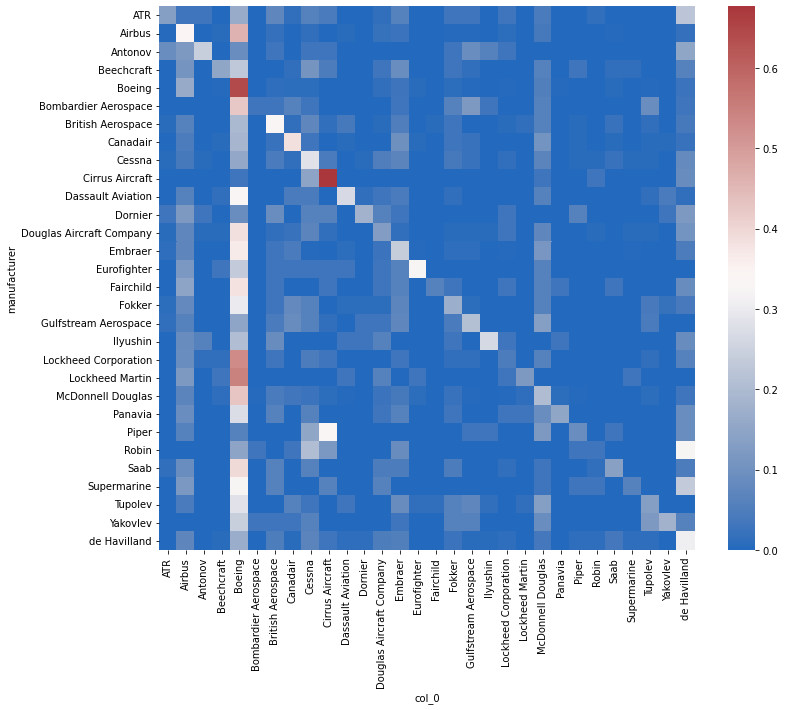

In [50]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME],
                        classify_images(X_test, model, test_df[TARGET_NAME].astype('category').cat.categories),
                        normalize='index'),
            cmap='vlag',
            ax=ax);

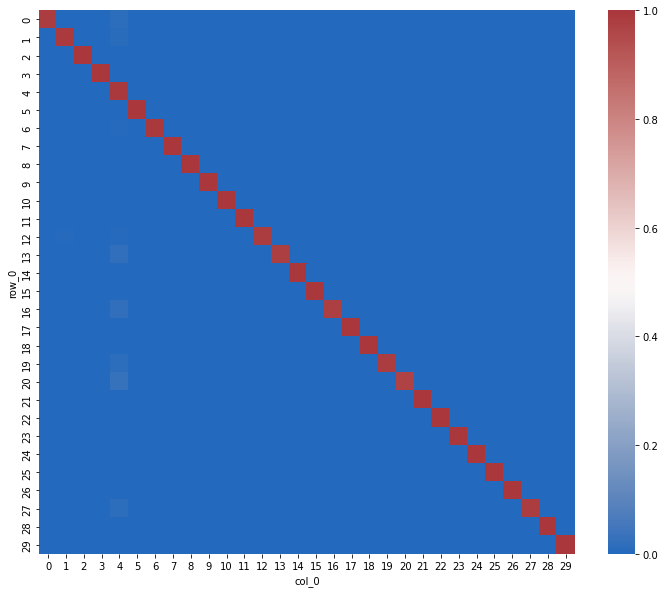

In [51]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(np.argmax(y_train, axis=1), classify_images(X_train, model), normalize='index'),
            cmap='vlag',
            ax=ax);

Save the model

In [185]:
# it records with date
import datetime

def save_model(model, basename, target):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  target(str): target variable
  """
  # save the model

  model.save(MODELS_DIR+"/"+ TARGET_NAME +".h5")
  return

In [186]:
save_model(model, 'model/planes', TARGET_NAME)

In [187]:
# see where it is registered + model weight
!ls -lh model

total 149M
-rw-r--r-- 1 root root 149M Apr  9 22:31 family.h5


##### reload the model

In [61]:
reloaded_model = load_model('/content/'+MODELS_DIR+'/'+TARGET_NAME+'.h5')

Extracting names

In [174]:
label = _df[TARGET_NAME].unique()
label = pd.DataFrame(label, columns = ['Aircraft'] )
label = label['Aircraft'].to_dict()

In [175]:
with open(r'label_'+TARGET_NAME+'.yaml','w') as file:
  label = yaml.dump(label, file)